In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

 94% 217M/230M [00:02<00:00, 102MB/s] 
100% 230M/230M [00:02<00:00, 109MB/s]


In [0]:
!unzip sarscov2-ctscan-dataset.zip

In [0]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

2.2.0


In [0]:
data_root=''
path_positive_cases = os.path.join('COVID')
path_negative_cases = os.path.join('non-COVID')

In [0]:
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))

In [0]:
covid = {'class': 'COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'non-COVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [0]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 1252
Total Negative Cases Covid19 images: 1229


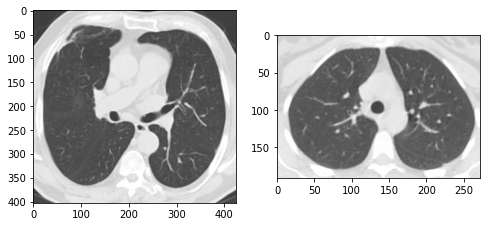

In [0]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [0]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (192, 272, 3)
Image Non COVID Shape (403, 425, 3)


In [0]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['COVID', 'non-COVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [0]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# define ratio of pictures used for testing 
test_ratio = 0.1


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

COVID 125
non-COVID 122


In [0]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [0]:
total_train_covid = len(os.listdir('train/COVID'))
total_train_noncovid = len(os.listdir('train/non-COVID'))
total_test_covid = len(os.listdir('test/COVID'))
total_test_noncovid = len(os.listdir('test/non-COVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 1127
Train sets images Non COVID: 1107
Test sets images COVID: 125
Test sets images Non COVID: 122


In [0]:
batch_size = 128
epochs = 30
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [0]:
train_dir = os.path.join('train')
test_dir = os.path.join('test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2234 images belonging to 2 classes.


In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 247 images belonging to 2 classes.


In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [0]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size
)

Epoch 1/30
17/17 [==============================] - 11s 638ms/step - loss: 0.7148 - accuracy: 0.5043 - val_loss: 0.6528 - val_accuracy: 0.5000
Epoch 2/30
17/17 [==============================] - 11s 639ms/step - loss: 0.6127 - accuracy: 0.5916 - val_loss: 0.5390 - val_accuracy: 0.6484
Epoch 3/30
17/17 [==============================] - 11s 645ms/step - loss: 0.4846 - accuracy: 0.7441 - val_loss: 0.4514 - val_accuracy: 0.8125
Epoch 4/30
17/17 [==============================] - 11s 640ms/step - loss: 0.4044 - accuracy: 0.8120 - val_loss: 0.3620 - val_accuracy: 0.7891
Epoch 5/30
17/17 [==============================] - 11s 645ms/step - loss: 0.3644 - accuracy: 0.8336 - val_loss: 0.2584 - val_accuracy: 0.8906
Epoch 6/30
17/17 [==============================] - 11s 637ms/step - loss: 0.3719 - accuracy: 0.8300 - val_loss: 0.4783 - val_accuracy: 0.7812
Epoch 7/30
17/17 [==============================] - 11s 637ms/step - loss: 0.3720 - accuracy: 0.8234 - val_loss: 0.2542 - val_accuracy: 0.8750

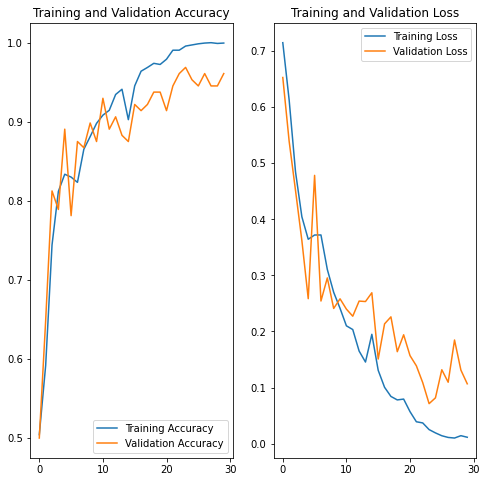

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()